# DL from the Foundations Batch Norm
> Implementing Batch Norm, Layer Norm, Instance Norm, Group Norm and running batch norm (Lesson 3 Part 4)

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/norms.png

In [2]:
#collapse
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#collapse
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [4]:
#collapse
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
#collapse
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
#collapse
nfs = [8,16,32,64,64]

In [7]:
#collapse
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
#collapse
%time run.fit(2, learn)

train: [1.22927203125, tensor(0.5976, device='cuda:0')]
valid: [0.190905224609375, tensor(0.9418, device='cuda:0')]
train: [0.17169419921875, tensor(0.9462, device='cuda:0')]
valid: [0.108160009765625, tensor(0.9669, device='cuda:0')]
CPU times: user 3.96 s, sys: 714 ms, total: 4.67 s
Wall time: 5.38 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch. We should be able to improve performance a lot. While training we keep a running exponentially weighted mean and variance average in the update_stats function. During inference we only use running mean and variance that we keep track off. We use `register_buffer`to create vars and means, this still creates `self.vars` and `self.means`, but if the model is moved to the GPU so will all buffers. Also it will be saved along with everything else in the model. 

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [13]:
#collapse_show
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        #we average over all batches (0) and over x,y(2,3) coordinates (each filter)
        #keepdim=True means we can still broadcast nicely as these dimensions will be left empty
        m = x.mean((0,2,3), keepdim=True)  
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

### Exponential moving average
We use exp. moving average, that way we only need to keep track of one element.The next value is computed with linear interpolation. PyTorch mom=0.1 is actually 0.9 in math terms. (1-mom)
![images](images/exp.png)


Now we define our batch norm conv_layer, when we use batch norm we can remove the bias layer as batch norm adds are a bias.  

In [15]:
#collapse_show
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [16]:
#collapse_show
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

Above the modules are initalized recursively. 
We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [17]:
#collapse
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

Train with Hooks : 

train: [0.092951201171875, tensor(0.9710, device='cuda:0')]
valid: [0.1474322998046875, tensor(0.9511, device='cuda:0')]


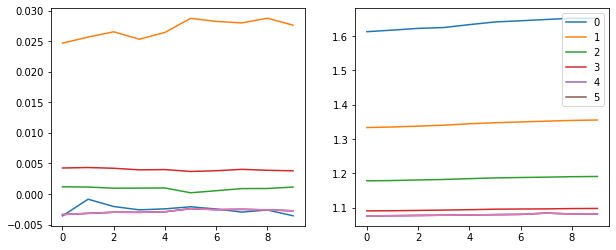

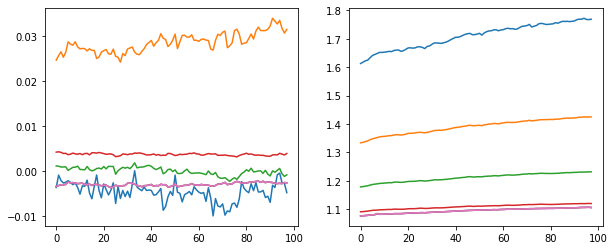

In [19]:
#collapse_show
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [21]:
#collapse
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [22]:
#collapse
%time run.fit(3, learn)

train: [0.2753326953125, tensor(0.9117, device='cuda:0')]
valid: [0.14528587646484376, tensor(0.9554, device='cuda:0')]
train: [0.08339517578125, tensor(0.9742, device='cuda:0')]
valid: [0.08496976318359376, tensor(0.9746, device='cuda:0')]
train: [0.06142646484375, tensor(0.9813, device='cuda:0')]
valid: [0.11257415771484375, tensor(0.9671, device='cuda:0')]
CPU times: user 3.36 s, sys: 92.7 ms, total: 3.45 s
Wall time: 3.4 s


### Builtin batchnorm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

In [23]:
#collapse_show
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [24]:
#collapse
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [26]:
#collapse
%time run.fit(3, learn)

train: [0.032240205078125, tensor(0.9905, device='cuda:0')]
valid: [0.0587533935546875, tensor(0.9817, device='cuda:0')]
train: [0.0237388916015625, tensor(0.9927, device='cuda:0')]
valid: [0.07805890502929687, tensor(0.9750, device='cuda:0')]
train: [0.018083040771484375, tensor(0.9945, device='cuda:0')]
valid: [0.060346484375, tensor(0.9837, device='cuda:0')]
CPU times: user 2.97 s, sys: 94.8 ms, total: 3.07 s
Wall time: 3.02 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [27]:
#collapse
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [28]:
#collapse_show
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [29]:
#collapse
run.fit(8, learn)

train: [0.239993203125, tensor(0.9268, device='cuda:0')]
valid: [0.1067057373046875, tensor(0.9680, device='cuda:0')]
train: [0.08213828125, tensor(0.9743, device='cuda:0')]
valid: [0.1173908203125, tensor(0.9617, device='cuda:0')]
train: [0.0569355517578125, tensor(0.9820, device='cuda:0')]
valid: [0.072092724609375, tensor(0.9790, device='cuda:0')]
train: [0.03151961181640625, tensor(0.9902, device='cuda:0')]
valid: [0.06193500366210938, tensor(0.9809, device='cuda:0')]
train: [0.019621298828125, tensor(0.9943, device='cuda:0')]
valid: [0.04464823913574219, tensor(0.9869, device='cuda:0')]
train: [0.011318720703125, tensor(0.9972, device='cuda:0')]
valid: [0.04040174865722656, tensor(0.9886, device='cuda:0')]
train: [0.007121054077148438, tensor(0.9986, device='cuda:0')]
valid: [0.040744146728515625, tensor(0.9888, device='cuda:0')]
train: [0.004829978637695313, tensor(0.9993, device='cuda:0')]
valid: [0.04020232238769531, tensor(0.9892, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*". This is the case for large Nets that only allow for small batch sizes. Also RNNs are a problem, as our for loop can not vary the batch size easily. 

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [30]:
#collapse_show
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

Keep in mind that compared to BN we use `m = x.mean((1,2,3), keepdim=True)` instead of `m=x.mean((0,2,3), keepdim=True)` and we do not use the exp. moving average. The reason is that every image has it's own mean as we do not use batches anymore. 

In [31]:
#collapse
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [32]:
#collapse_show
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [33]:
#collapse_show
%time run.fit(3, learn)

train: [nan, tensor(0.1256, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.95 s, sys: 73.9 ms, total: 4.03 s
Wall time: 3.98 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?       
No we can not, layer norm will lead to the same normalization for both pictures. As we can see LN is not as good as BN, but it can be used for RNNS. 

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [34]:
#collapse_show
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

Keep in mind that compared to LN we use `m = x.mean((2,3), keepdim=True)` instead of `m=x.mean((1,2,3), keepdim=True)`.

In [35]:
#collapse
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [36]:
#collapse
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [37]:
#collapse
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4 s, sys: 58.2 ms, total: 4.05 s
Wall time: 4.01 s


*Question*: why can't this classify anything?  
We are now using the mean and variance for every image and every channel, throwing away the things that allow classification. 
It was not designed for Classification, but rather for style transfer where the differences in contrast and overall amount are not important according to the authors. 

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [38]:
#collapse
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [39]:
#collapse_show
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [40]:
#collapse
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [41]:
#collapse
%time run.fit(1, learn)

train: [2.3343459375, tensor(0.1976, device='cuda:0')]
valid: [680970.0864, tensor(0.2176, device='cuda:0')]
CPU times: user 1min 29s, sys: 759 ms, total: 1min 30s
Wall time: 1min 30s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std. Eps is used to avoid divergence, it is used as a hyperparameter. Running Batch Norm is a good solution (best so far according to Jeremy) for the small batch size problem.    

1) It does not divide by the batch standard deviation, but it uses the moving average stats at training time as well, just like during inference. Accuracy increases a lot ! As we should not compute the running average of the variances, especially as they might be different batch sizes as well. We use the formula :   
$E[X^{2}]-E[X]^{2}$     
So we use the squares and the sums with a buffer.   

2) And then we take the exp. moving average of these and interpolate. We also take the exponential moving average of the batch sizes, it tells us what we need to divide by : (total number of elements by the mini batch divided by number of channels) 

3) Debiasing    
Make sure that at every point, no observation is weighted too much. (early elements have more relevance as they appear more often) 
![images](images/debiasing.png)   


4) For the first elements : 
We might be unlucky, so that our first mini batch is very close to zero. So we clamp the first few elements (for example 20) variance to be 0.01. 

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [42]:
#collapse_show
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [43]:
#collapse_show
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [44]:
#collapse
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [45]:
#collapse
%time run.fit(1, learn)

train: [0.418019921875, tensor(0.8890, device='cuda:0')]
valid: [0.1741728515625, tensor(0.9607, device='cuda:0')]
CPU times: user 3min 56s, sys: 1.22 s, total: 3min 58s
Wall time: 3min 58s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [46]:
#collapse
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [47]:
#collapse
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [48]:
#collapse
%time run.fit(1, learn)

train: [0.154025556640625, tensor(0.9523, device='cuda:0')]
valid: [0.2699001953125, tensor(0.9759, device='cuda:0')]
CPU times: user 15.1 s, sys: 70.4 ms, total: 15.1 s
Wall time: 15.1 s


## Export

In [49]:
nb_auto_export()

<IPython.core.display.Javascript object>